## Hackathon

In [41]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.fft import fft, fftfreq, ifft
from scipy.optimize import curve_fit
from functools import partial

xr.set_options(display_style="text")

## Data loader om data uit de grote set te halen.

Gebruik `loader.get_subset()` voor specifieke ranges van tijd, longitude en latitude. 

Gebruik `subset.to_dataframe()` om een tabel van type xarray om te zetten naar een pandas dataframe. 

In [42]:
class DataLoader:
    """Simple dataloader for NetCDF temperature data."""
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.dataset = None
    
    def load_data(self):
        """Load and preprocess the dataset."""
        self.dataset = xr.open_dataset(self.file_path, engine="h5netcdf")
        
        # Fix coordinates
        if self.dataset["longitude"].max() > 180:
            self.dataset = self.dataset.assign_coords(
                longitude=(self.dataset["longitude"].values + 180) % 360 - 180
            )
        if self.dataset["latitude"].max() > 90:
            self.dataset = self.dataset.assign_coords(
                latitude=self.dataset["latitude"].values - 90
            )
        
        # Sort coordinates
        self.dataset = self.dataset.sortby(["latitude", "longitude"])
        return self.dataset
    
    def get_subset(self, time_range=None, lat_range=None, lon_range=None):
        """Get a subset of the data (handles both time and valid_time safely)."""
        if self.dataset is None:
            raise ValueError("Load data first!")

        subset = self.dataset

        # Determine which time coordinate exists AND is indexable
        if "valid_time" in subset.coords and "valid_time" in subset.dims:
            time_coord = "valid_time"
        elif "time" in subset.coords and "time" in subset.dims:
            time_coord = "time"
        else:
            print("⚠️ Warning: No indexable time coordinate found, skipping time filtering.")
            time_coord = None

        # Apply filters
        if time_coord and time_range:
            subset = subset.sel({time_coord: slice(time_range[0], time_range[1])})
        if lat_range:
            subset = subset.sel(latitude=slice(lat_range[0], lat_range[1]))
        if lon_range:
            subset = subset.sel(longitude=slice(lon_range[0], lon_range[1]))

        return subset.compute()



In [43]:
# Example usage
loader = DataLoader("2023_2m_temperature.nc")
dataset = loader.load_data()

loader2 = DataLoader("ERA5_wind.nc")
dataset2 = loader2.load_data()

In [44]:
# Get a subset (May 2023, Europe)
subset = loader.get_subset(
    time_range=("2023-01-01", "2023-12-31"),
    lat_range=(52.25, 52.25),
    lon_range=(5.0, 5.0)
)

print(loader)

subset2 = loader2.get_subset(
    time_range=("2023-05-01", "2023-05-31"),
    lat_range=(52.0, 53.0),
    lon_range=(4.0, 6.0)
)



In [45]:
subset["t2m"].data.flatten()[0:10]

array([287.72104, 287.52673, 287.25696, 286.77545, 285.91565, 285.18488,
       284.83664, 284.40027, 284.11185, 284.33044], dtype=float32)

In [46]:
subset_df = subset.to_dataframe().reset_index()
subset_df = subset_df.drop(['number', 'expver'], axis=1)
subset.to_dataframe()

mean_t2m = dataset['t2m'].sel(valid_time=slice("2023-05-01", "2023-05-31")).mean(dim='valid_time')

subset2_df = subset2.to_dataframe().reset_index()
subset2_df = subset2_df.drop(columns=['time', 'number', 'step', 'surface'], errors='ignore')

print(subset2_df.info(), subset_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33480 entries, 0 to 33479
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   latitude    33480 non-null  float64       
 1   longitude   33480 non-null  float64       
 2   valid_time  33480 non-null  datetime64[ns]
 3   u10         33480 non-null  float32       
 4   v10         33480 non-null  float32       
dtypes: datetime64[ns](1), float32(2), float64(2)
memory usage: 1.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   valid_time  8760 non-null   datetime64[ns]
 1   latitude    8760 non-null   float64       
 2   longitude   8760 non-null   float64       
 3   t2m         8760 non-null   float32       
dtypes: datetime64[ns](1), float32(1), float64(2)
memory usage: 239.7 KB
None None


In [47]:
fig = px.line(subset_df, x='valid_time', y='t2m')
fig.show()

## Methode om je forecast functie te evalueren op een random steekproef van de dataset. 
In dit voorbeeld wordt steeds 2 weken historische data gepakt en wordt 1 week vooruit voorspeld.

`generate_eval_data()` geeft n random periodes van 3 weken op willekeurige locaties.

`forecast(history, n_points)` neemt een historische reeks van temperaturen en voorspelt de volgende n_points.

`forecast_1w()` evalueert de forecast functie op een random week (MAE score) en toont een grafiek van de historische reeks, de echte waardes en de voorspelde waarde. 

`evaluator(function, n_samples)` berekent de mean absolute error (MAE) van de voorspelling van functie `forecast()` voor een steekproef van grootte n_samples. 

In [48]:
def generate_eval_data(n = 100):
    rng = np.random.default_rng()
    
    # ---- Random geolocation ----
    # Longitude uniform in [-180, 180)
    lon = rng.uniform(-25, 37.25, n)
    lon = np.round(lon * 4)/4
    
    # Latitude area-uniform: sample z = sin(lat) ~ U(-1,1)  => lat = arcsin(z)
    lat = rng.uniform(34, 71.25, n)
    lat = np.round(lat * 4)/4
    
    # ---- Random 3-week interval in 2023 ----
    start0 = pd.Timestamp("2023-01-01")
    # Inclusive end = start + 20 days (21 calendar days total)
    last_start = pd.Timestamp("2023-12-31") - pd.Timedelta(days=20)
    num_choices = (last_start - start0).days + 1
    
    offsets = rng.integers(0, num_choices, n)  # days after Jan 1
    start_date = start0 + pd.to_timedelta(offsets, unit="D")
    end_date = start_date + pd.Timedelta(days=20)
    
    # ---- Assemble DataFrame ----
    df = pd.DataFrame({
        "latitude_deg": lat,
        "longitude_deg": lon,
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d")
    })

    return df

In [49]:
def generate_eval_data_non_rand(lon, lat, start_date=['2023-05-01'], end_date=['2023-05-21']):
    # ---- Assemble DataFrame ----
    df = pd.DataFrame({
        "latitude_deg": lat,
        "longitude_deg": lon,
        "start_date": start_date,
        "end_date": end_date
    })
    return df

In [50]:
generate_eval_data(5)

,latitude_deg,longitude_deg,start_date,end_date
0,39.25,28.75,2023-03-27,2023-04-16
1,43.00,-8.00,2023-04-08,2023-04-28
2,67.00,-1.25,2023-09-08,2023-09-28
3,62.50,23.00,2023-10-18,2023-11-07
4,46.25,4.25,2023-03-03,2023-03-23


In [51]:
def sine_model(x, A, b, c, d):
    sin = A * np.sin(2*np.pi/c * (x+b)) + d
    return sin

def sine_from_fft(t, freq, amplitude, phase, offset=0):
    return amplitude * np.sin(2 * np.pi * freq * t + phase) + offset

In [52]:
def ARIMA_sine_fitted(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):

    
    # N = len(history)
    # T = 1.0  # als tijdstap 1 uur is
    # yf = fft(history)
    # xf = fftfreq(N, T)[:N//2]

    # magnitude = np.abs(yf[:N//2])
    # phase = np.angle(yf[:N//2])
    # magnitude[0] = 0

    # top_idxs = np.argsort(magnitude)[-1:]
    # top_freqs = xf[top_idxs]
    # top_amps = 2.0 / N * magnitude[top_idxs]
    # top_phases = phase[top_idxs]

    # top_waves = 2.0 / N * magnitude[top_idxs]

    # plt.plot(xf, 2.0 / N * magnitude, label='Spectrum')
    # plt.scatter(xf[top_idxs], top_waves, color='red', label='Top 3 peaks')
    # plt.legend()
    # plt.show()

    # # === Plot ===
    t = np.arange(len(history))
    # fig, ax = plt.subplots(figsize=(10,5))
    # ax.plot(t, history, label='Original signal', color='black', alpha=0.6)

    # optionally: combined reconstruction
    # y_sum = np.sum([sine_from_fft(t, f, a, p)
    #                 for f, a, p in zip(top_freqs, top_amps, top_phases)], axis=0) + np.mean(history)
    # ax.plot(t, y_sum, label='Sum of top waves', color='red', linewidth=2)

    # ax.legend()
    # plt.show()

    guess = [10, 0, 24, np.mean(history)]  
    # limieten: [A1, b1, c1, d1]
    lower = [0, -24, 0, 0]
    upper = [20, 24, 25, 320]

    try:
        params, pcov = curve_fit(sine_model, np.arange(len(history)), history, p0=guess, bounds=(lower, upper))
        A, b, c, d= params

        d -= np.mean(history)
    except:
        A, b, c, d = [0.0, 0.0, 1.0, 0.0]

    y = sine_model(t, A, b, c, d)

    model = sm.tsa.ARIMA(history, order=(1, 0, 0)).fit()

    forecast = model.forecast(steps=n_points)
    x = np.arange(start=len(history), stop=len(history) + n_points)

    # y_fft_future = np.sum([
    #     sine_from_fft(x, f, a, p)
    #     for f, a, p in zip(top_freqs, top_amps, top_phases)
    # ], axis=0)# + np.mean(history)

    forecast_fitted = forecast + sine_model(x, A, b, c, d)

    return forecast_fitted

In [53]:
def AR1(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    mu = np.mean(history)
    sigma = np.std(history)

    X = [history[-1]]

    phi = .9

    for t in range(1, n_points):
        eps = np.random.normal(0, sigma)
        x_t = mu + phi * (X[-1] - mu) + eps * .1

        #print(X[t-1])

        X.append(x_t)

    return X

In [54]:
def AR1_sine_fitted(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):

    t = np.arange(len(history))

    guess = [10, 0, 24, np.mean(history)]  
    # limieten: [A1, b1, c1, d1]
    lower = [0, -24, 0, 0]
    upper = [20, 24, 25, 320]

    params, pcov = curve_fit(sine_model, np.arange(len(history)), history, p0=guess, bounds=(lower, upper))
    A, b, c, d= params

    d -= np.mean(history)

    y = sine_model(t, A, b, c, d)


    forecast = AR1(history, lon, lat, start_date_hist, end_date_hist)

    x = np.arange(start=len(history), stop=len(history) + n_points)
    forecast_fitted = forecast + sine_model(x, A, b, c, d)

    return forecast_fitted

In [55]:
def forecast(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    # Take the last point of the history and repeat it n_points times
    try:
        return np.full(n_points, history[-1])
    except: 
        return np.full(n_points, 0)

def forecast_1w(row, function, operation = 'loop'):
    sample = loader.get_subset(
            time_range=(row['start_date'], row['end_date']),
            lat_range=(row['latitude_deg'], row['latitude_deg']),
            lon_range=(row['longitude_deg'], row['longitude_deg'])
        ).compute()
    history = sample.sel(valid_time=slice(row['start_date'],(pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d")))['t2m'].data.flatten()
    y_true = sample.sel(valid_time=slice((pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"),row['end_date']))['t2m'].data.flatten()
    y_pred = function(history, 
                      row['longitude_deg'], 
                      row['latitude_deg'], 
                      row['start_date'],
                      (pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"), 
                      len(y_true))
    if operation == 'manual':
        fig, ax = plt.subplots()
        ax.plot(range(len(history)), history, color = 'blue')
        ax.plot(range(len(history), len(history) + len(y_true)), y_true, color = 'blue', linestyle = 'dashed')
        ax.plot(range(len(history), len(history) + len(y_true)), y_pred, color = 'green', linestyle = (0, (1, 1)))
        #ax.plot(range(len(history), len(history) + len(y_true)), y_pred_fitted, color = 'red', linestyle = (0, (1, 1)))
        plt.show()
    return np.mean(np.abs(y_true - y_pred))#, np.abs(y_true - y_pred)#, np.mean(np.abs(y_true - y_pred_fitted))


In [56]:
forecast(np.array([9,8,18]), n_points = 5)

array([18, 18, 18, 18, 18])

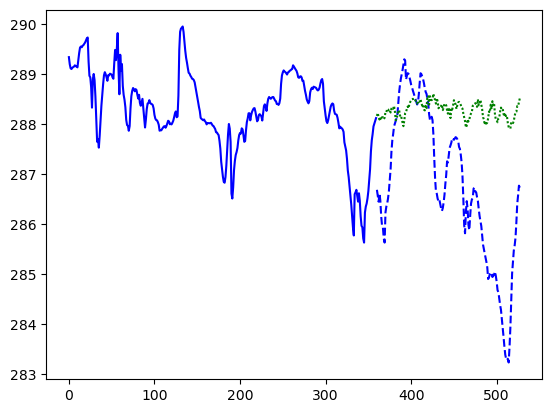

1.7102409062780215

In [ ]:
#forecast_1w(generate_eval_data(1).iloc[0], forecast, 'manual')
forecast_1w(generate_eval_data(1).iloc[0], AR1_sine_fitted, 'manual')



In [58]:
def evaluator(function, n_samples = 100):
    errors = []
    #errors_fitted = []
    df = generate_eval_data(n_samples)
    for index, row in df.iterrows():
        error= forecast_1w(row, function, operation = 'loop')
        errors.append(error)
        
        #x = np.arange(len(error_vals))

        #plt.plot(x, error_vals)
        #errors_fitted.append(error_fitted)
    return np.mean(errors)#, np.mean(errors_fitted)

In [59]:
evaluator(forecast, 100)

2.3304129

In [60]:
# error_df_forecast = pd.DataFrame(columns=['lon', 'lat', 'error'])

# for lat in range(3400, 7150, 25):
#     for lon in range(-2500, 3750, 25):
#         df = generate_eval_data_non_rand(lon / 100, lat/ 100)
#         error= forecast_1w(df.iloc[0], forecast, operation = 'loop')
#         error_df_forecast.loc[len(error_df_forecast)] = [lon, lat, error]

In [61]:
error_df = pd.read_csv('forecast_error.csv', index_col='Unnamed: 0')
error_df.head()

,lon,lat,error
0,-25.00,34.0,0.677149
1,-24.75,34.0,0.693917
2,-24.50,34.0,0.654191
3,-24.25,34.0,0.619303
4,-24.00,34.0,0.552519


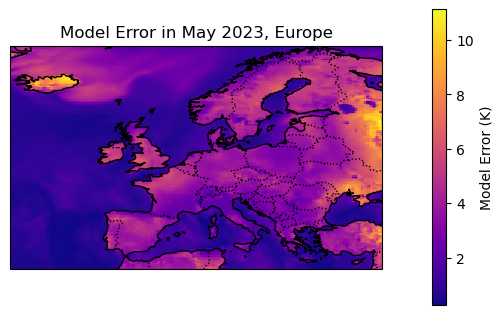

2.699398557375272


In [62]:
# Vind unieke waarden
lons = np.sort(error_df['lon'].unique())
lats = np.sort(error_df['lat'].unique())

# Reshape error naar 2D-array
error_grid = error_df['error'].values.reshape(len(lats), len(lons))



# Maak meshgrid
LON, LAT = np.meshgrid(lons, lats)

# Plot
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

pcm = ax.pcolormesh(LON, LAT, error_grid, cmap='plasma', shading='auto')

ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# GEEN gridlines: verwijder ax.gridlines entirely

cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.1, shrink=0.8)
cbar.set_label('Model Error (K)')

ax.set_title('Model Error in May 2023, Europe')
plt.savefig('errors2.png', dpi=1000)
plt.show()

print(error_df['error'].mean())

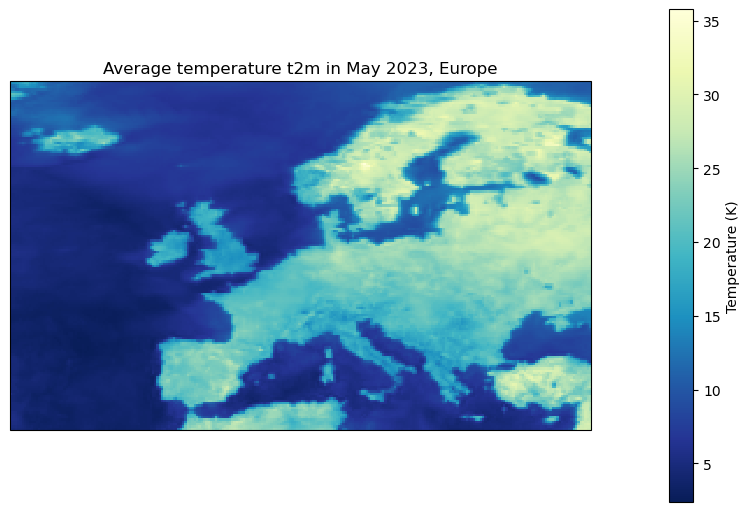

In [63]:
# Task 1
lats = np.linspace(34, 71.25, 150)
lons = np.linspace(-25, 37.25, 250)

LON, LAT = np.meshgrid(lons, lats)

t2m_values = loader.get_subset(
    time_range=("2023-05-01", "2023-05-31"),
    lat_range=(34, 71.25),
    lon_range=(-25, 37.25)
)

monthly_mean = t2m_values['t2m'].max(dim='valid_time').values - t2m_values['t2m'].min(dim='valid_time').values

coords = np.stack([LAT, LON], axis=-1)

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

pcm = ax.pcolormesh(
    LON, LAT, monthly_mean,
    cmap='YlGnBu_r',
    shading='auto'
)

# Add country borders
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.COASTLINE)

# gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.1, shrink=0.8)
cbar.set_label('Temperature (K)')

ax.set_title('Average temperature t2m in May 2023, Europe')
plt.savefig('temp_differences.png', dpi=1000)
plt.show()


In [64]:
def normalize_centered(arr):
    max_val = np.max(np.abs(arr))
    return (arr / (2 * max_val + 1e-8)) + 0.5

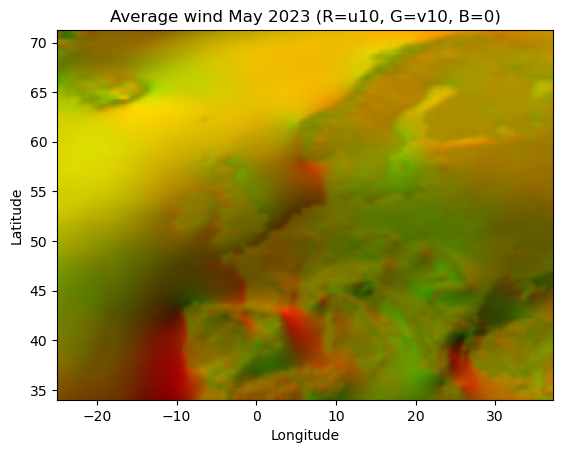

In [82]:
# --- Coordinates ---
lats = np.linspace(34, 71.25, 150)
lons = np.linspace(-25, 37.25, 250)
LON, LAT = np.meshgrid(lons, lats)

# --- Load subset ---
t2m_values = loader2.get_subset(
    time_range=("2023-05-01", "2023-05-31"),
    lat_range=(34, 71.25),
    lon_range=(-25, 37.25)
)

# --- Compute mean wind ---
u_mean = t2m_values['u10'].mean(dim='time').values
v_mean = t2m_values['v10'].mean(dim='time').values

# --- Normalize around 0 for correct colors ---
def normalize_centered(arr):
    max_val = np.max(np.abs(arr))
    return (arr / (2*max_val + 1e-8)) + 0.5

r = normalize_centered(u_mean)
g = normalize_centered(v_mean)
b = np.zeros_like(r)

rgb = np.stack([r, g, b], axis=-1)

# --- Plot with imshow ---
fig, ax = plt.subplots()

# extent = [xmin, xmax, ymin, ymax] in real coordinates
extent = [lons.min(), lons.max(), lats.min(), lats.max()]
ax.imshow(rgb, origin='lower', extent=extent, aspect='auto')

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Average wind May 2023 (R=u10, G=v10, B=0)")

plt.savefig('wind.png', dpi=1000)
plt.show()



lon      37.000000
lat      58.500000
error    11.124289
Name: 24748, dtype: float64


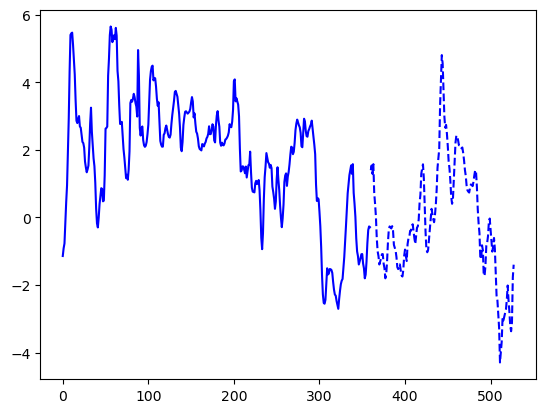

lon      37.00000
lat      58.25000
error    10.86783
Name: 24498, dtype: float64


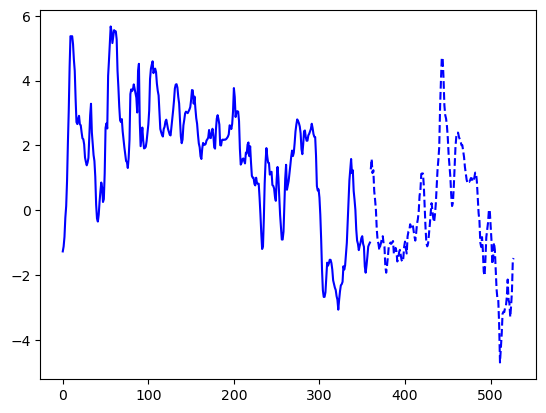

lon      37.000000
lat      58.750000
error    10.795143
Name: 24998, dtype: float64


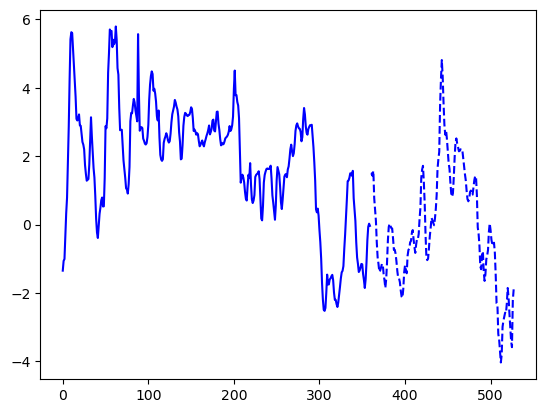

lon      37.000000
lat      58.000000
error    10.765138
Name: 24248, dtype: float64


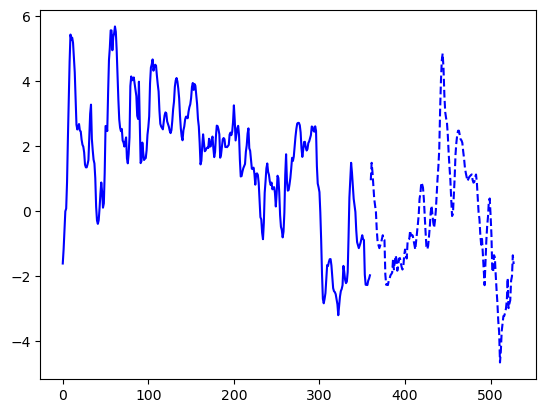

lon      36.75000
lat      58.75000
error    10.75366
Name: 24997, dtype: float64


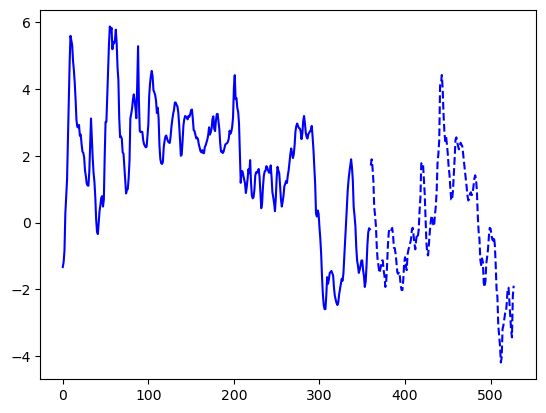

In [ ]:
rows = error_df.sort_values(ascending=False, by='error')[:5]

# Sorteer top 5 errors
rows = error_df.sort_values(by='error', ascending=False).head(5)

for _, row in rows.iterrows():
    lon = row['lon']
    lat = row['lat']

    # Genereer data en forecast
    df = generate_eval_data_non_rand(lon, lat).reset_index()
    df = df.set_index('index')
    error = forecast_1w(df.iloc[0], ARIMA_sine_fitted, operation='loop')

    print(row)

    sample = loader2.get_subset(
    time_range=(df['start_date'].iloc[0], df['end_date'].iloc[0]),
    lat_range=(df['latitude_deg'].iloc[0], df['latitude_deg'].iloc[0]),
    lon_range=(df['longitude_deg'].iloc[0], df['longitude_deg'].iloc[0])
    ).compute()

    history = sample.sel(time=slice(df['start_date'].iloc[0],(pd.to_datetime(df['start_date'].iloc[0]) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d")))['u10'].data.flatten()
    y_true = sample.sel(time=slice((pd.to_datetime(df['start_date'].iloc[0]) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"),df['end_date'].iloc[0]))['u10'].data.flatten()

    t = np.arange(len(history))

    fig, ax = plt.subplots()

    ax.plot(range(len(history)), history, color = 'blue')
    ax.plot(range(len(history), len(history) + len(y_true)), y_true, color = 'blue', linestyle = 'dashed')
    plt.show()
